In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start: end], series[start: end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [4]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [5]:
split_time = 1000
time_train = time[: split_time]
x_train = series[: split_time]

time_valid = time[split_time: ]
x_valid = series[split_time: ]

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer = 1000

def window_dataset(series, window_size, batch_size, shuffle_buffer):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift = 1, drop_remainder = True)
    data = data.flat_map(lambda window: window.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer).map(lambda window: (window[: -1], window[-1:]))
    data = data.batch(batch_size).prefetch(1)
    return data

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

data = window_dataset(x_train, window_size, batch_size, shuffle_buffer)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9),
              metrics = ['mae'])
history = model.fit(data, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 16ms/step - loss: 19.7112 - mae: 20.2030 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 19.1291 - mae: 19.6197 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 18.5123 - mae: 19.0080 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 17.8734 - mae: 18.3689 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 16.9595 - mae: 17.4557 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 14.2901 - mae: 14.7857 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 13.6736 - mae: 14.1667 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 13.4517 - mae: 13.9431 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 13.2552 - mae:

31/31 [==============================] - 0s 11ms/step - loss: 4.8589 - mae: 5.3389 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 11ms/step - loss: 6.5459 - mae: 7.0324 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 12ms/step - loss: 5.2233 - mae: 5.7029 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 11ms/step - loss: 5.4253 - mae: 5.9075 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 10ms/step - loss: 5.3430 - mae: 5.8250 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 11ms/step - loss: 5.6016 - mae: 6.0908 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 12ms/step - loss: 6.4214 - mae: 6.9038 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 13ms/step - loss: 6.1559 - mae: 6.6417 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 11ms/step - loss: 6.7629 - mae: 7.2471 - lr: 1.0000e

(1e-08, 0.0001, 0.0, 30.0)

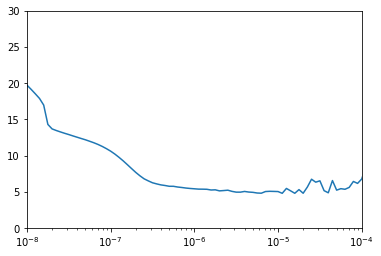

In [15]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()
data = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(data, epochs = 500)

Epoch 1/500
31/31 [==============================] - 5s 13ms/step - loss: 3897.7339 - mae: 44.5896
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 257.0816 - mae: 12.9379
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 123.2741 - mae: 8.5625
Epoch 4/500
31/31 [==============================] - 0s 12ms/step - loss: 175.8133 - mae: 10.4873
Epoch 5/500
31/31 [==============================] - 0s 11ms/step - loss: 127.2908 - mae: 8.8392
Epoch 6/500
31/31 [==============================] - 0s 11ms/step - loss: 80.6335 - mae: 6.8605
Epoch 7/500
31/31 [==============================] - 0s 12ms/step - loss: 106.1442 - mae: 8.1223
Epoch 8/500
31/31 [==============================] - 0s 11ms/step - loss: 70.9872 - mae: 6.5405
Epoch 9/500
31/31 [==============================] - 0s 11ms/step - loss: 82.0263 - mae: 7.0231
Epoch 10/500
31/31 [==============================] - 0s 11ms/step - loss: 147.8513 - mae: 9.6232
Epoch 11/500
31/31 [========

31/31 [==============================] - 0s 11ms/step - loss: 48.4549 - mae: 5.2347
Epoch 86/500
31/31 [==============================] - 0s 11ms/step - loss: 64.0777 - mae: 6.0454
Epoch 87/500
31/31 [==============================] - 0s 11ms/step - loss: 78.5920 - mae: 6.9755
Epoch 88/500
31/31 [==============================] - 0s 11ms/step - loss: 51.9809 - mae: 5.4978
Epoch 89/500
31/31 [==============================] - 0s 11ms/step - loss: 53.1484 - mae: 5.5118
Epoch 90/500
31/31 [==============================] - 0s 11ms/step - loss: 50.4299 - mae: 5.4374
Epoch 91/500
31/31 [==============================] - 0s 11ms/step - loss: 57.4335 - mae: 5.8853
Epoch 92/500
31/31 [==============================] - 0s 11ms/step - loss: 55.1098 - mae: 5.7384
Epoch 93/500
31/31 [==============================] - 0s 13ms/step - loss: 55.8438 - mae: 5.7081
Epoch 94/500
31/31 [==============================] - 0s 12ms/step - loss: 44.3260 - mae: 5.0324
Epoch 95/500
31/31 [=======================

31/31 [==============================] - 0s 12ms/step - loss: 44.7728 - mae: 5.0386
Epoch 169/500
31/31 [==============================] - 0s 12ms/step - loss: 42.0437 - mae: 4.8783
Epoch 170/500
31/31 [==============================] - 0s 11ms/step - loss: 46.3316 - mae: 5.2252
Epoch 171/500
31/31 [==============================] - 0s 12ms/step - loss: 47.5010 - mae: 5.2236
Epoch 172/500
31/31 [==============================] - 0s 12ms/step - loss: 59.3065 - mae: 5.8799
Epoch 173/500
31/31 [==============================] - 0s 11ms/step - loss: 51.2002 - mae: 5.4781
Epoch 174/500
31/31 [==============================] - 0s 14ms/step - loss: 45.9856 - mae: 5.1860
Epoch 175/500
31/31 [==============================] - 0s 11ms/step - loss: 41.8966 - mae: 4.9264
Epoch 176/500
31/31 [==============================] - 0s 12ms/step - loss: 45.0504 - mae: 5.0849
Epoch 177/500
31/31 [==============================] - 0s 11ms/step - loss: 48.7293 - mae: 5.2987
Epoch 178/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 41.0220 - mae: 4.8139
Epoch 252/500
31/31 [==============================] - 0s 12ms/step - loss: 42.2438 - mae: 4.8815
Epoch 253/500
31/31 [==============================] - 0s 12ms/step - loss: 40.9522 - mae: 4.8142
Epoch 254/500
31/31 [==============================] - 0s 12ms/step - loss: 38.4838 - mae: 4.7039
Epoch 255/500
31/31 [==============================] - 0s 12ms/step - loss: 41.8717 - mae: 4.9394
Epoch 256/500
31/31 [==============================] - 0s 12ms/step - loss: 42.1244 - mae: 4.9020
Epoch 257/500
31/31 [==============================] - 0s 11ms/step - loss: 44.2580 - mae: 5.0045
Epoch 258/500
31/31 [==============================] - 0s 12ms/step - loss: 44.6293 - mae: 5.1003
Epoch 259/500
31/31 [==============================] - 0s 12ms/step - loss: 44.3668 - mae: 5.0790
Epoch 260/500
31/31 [==============================] - 0s 12ms/step - loss: 42.6869 - mae: 4.9001
Epoch 261/500
31/31 [=============

31/31 [==============================] - 0s 12ms/step - loss: 42.0792 - mae: 4.9101
Epoch 335/500
31/31 [==============================] - 0s 12ms/step - loss: 39.3153 - mae: 4.7374
Epoch 336/500
31/31 [==============================] - 0s 13ms/step - loss: 41.0855 - mae: 4.8896
Epoch 337/500
31/31 [==============================] - 0s 13ms/step - loss: 41.8498 - mae: 4.8919
Epoch 338/500
31/31 [==============================] - 0s 13ms/step - loss: 43.5974 - mae: 5.0248
Epoch 339/500
31/31 [==============================] - 0s 12ms/step - loss: 42.7784 - mae: 4.9195
Epoch 340/500
31/31 [==============================] - 0s 12ms/step - loss: 41.6946 - mae: 4.8342
Epoch 341/500
31/31 [==============================] - 0s 11ms/step - loss: 42.3364 - mae: 4.8542
Epoch 342/500
31/31 [==============================] - 0s 13ms/step - loss: 39.5805 - mae: 4.7067
Epoch 343/500
31/31 [==============================] - 0s 11ms/step - loss: 39.6494 - mae: 4.7360
Epoch 344/500
31/31 [=============

31/31 [==============================] - 0s 13ms/step - loss: 37.0206 - mae: 4.6067
Epoch 418/500
31/31 [==============================] - 0s 11ms/step - loss: 42.6585 - mae: 4.9790
Epoch 419/500
31/31 [==============================] - 0s 13ms/step - loss: 37.5382 - mae: 4.6324
Epoch 420/500
31/31 [==============================] - 0s 12ms/step - loss: 39.9876 - mae: 4.7910
Epoch 421/500
31/31 [==============================] - 0s 12ms/step - loss: 41.3300 - mae: 4.8706
Epoch 422/500
31/31 [==============================] - 0s 12ms/step - loss: 41.1761 - mae: 4.8338
Epoch 423/500
31/31 [==============================] - 0s 12ms/step - loss: 37.3806 - mae: 4.6100
Epoch 424/500
31/31 [==============================] - 0s 12ms/step - loss: 37.8177 - mae: 4.6219
Epoch 425/500
31/31 [==============================] - 0s 12ms/step - loss: 38.3554 - mae: 4.6766
Epoch 426/500
31/31 [==============================] - 0s 12ms/step - loss: 51.5012 - mae: 5.4622
Epoch 427/500
31/31 [=============

31/31 [==============================] - 0s 12ms/step - loss: 40.5591 - mae: 4.8554


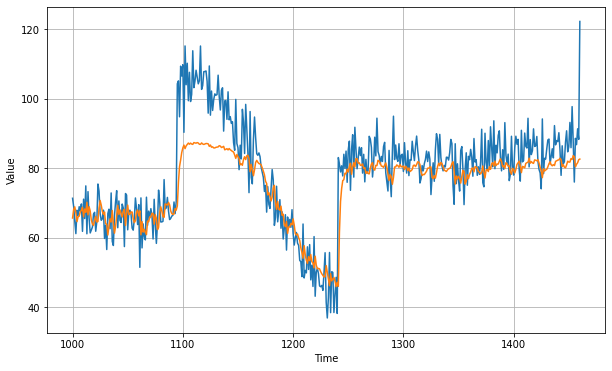

In [20]:
forecast = []
results = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time : time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.352829

<Figure size 432x288 with 0 Axes>

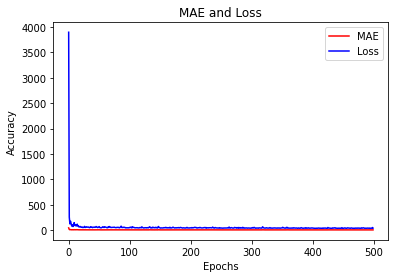

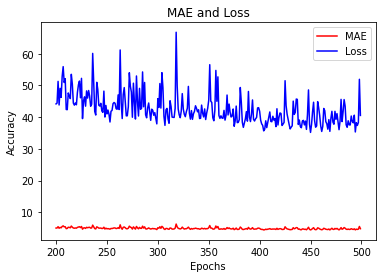

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [23]:
tf.keras.backend.clear_session()
data = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(data, epochs = 100)

Epoch 1/100
31/31 [==============================] - 4s 14ms/step - loss: 941.0788 - mae: 20.8721
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 121.9658 - mae: 8.1524
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 84.6847 - mae: 6.6327
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 71.3997 - mae: 5.9362
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 84.4238 - mae: 6.8174
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 66.8737 - mae: 5.9778
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 66.6184 - mae: 5.9453
Epoch 8/100
31/31 [==============================] - 0s 12ms/step - loss: 73.1399 - mae: 6.4283
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 63.8649 - mae: 6.0019
Epoch 10/100
31/31 [==============================] - 0s 14ms/step - loss: 59.8184 - mae: 5.7283
Epoch 11/100
31/31 [================

31/31 [==============================] - 0s 12ms/step - loss: 50.2317 - mae: 5.3607
Epoch 86/100
31/31 [==============================] - 0s 13ms/step - loss: 47.1367 - mae: 5.1772
Epoch 87/100
31/31 [==============================] - 0s 12ms/step - loss: 44.6939 - mae: 5.0043
Epoch 88/100
31/31 [==============================] - 0s 11ms/step - loss: 43.2225 - mae: 4.8988
Epoch 89/100
31/31 [==============================] - 0s 11ms/step - loss: 43.8945 - mae: 4.9361
Epoch 90/100
31/31 [==============================] - 0s 12ms/step - loss: 48.1140 - mae: 5.1671
Epoch 91/100
31/31 [==============================] - 0s 12ms/step - loss: 44.5501 - mae: 4.9791
Epoch 92/100
31/31 [==============================] - 0s 11ms/step - loss: 44.1342 - mae: 4.9809
Epoch 93/100
31/31 [==============================] - 0s 11ms/step - loss: 44.9902 - mae: 4.9900
Epoch 94/100
31/31 [==============================] - 0s 11ms/step - loss: 44.8903 - mae: 5.0114
Epoch 95/100
31/31 [=======================

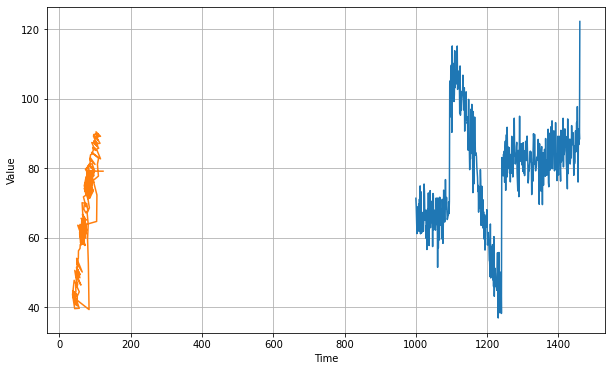

In [24]:
forecast = []
results = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time : time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size: ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(x_valid, results)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.044566

In [26]:
tf.keras.backend.clear_session()
data = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(data, epochs = 100)

Epoch 1/100
31/31 [==============================] - 6s 20ms/step - loss: 316.2706 - mae: 13.0176
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 94.0377 - mae: 6.8192
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 77.2804 - mae: 6.1096
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 77.5018 - mae: 6.3266
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 77.1151 - mae: 6.3589
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 69.3253 - mae: 5.9635
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 63.8911 - mae: 5.7226
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 68.7067 - mae: 6.0060
Epoch 9/100
31/31 [==============================] - 1s 19ms/step - loss: 59.2160 - mae: 5.4940
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 57.6547 - mae: 5.4255
Epoch 11/100
31/31 [=================

31/31 [==============================] - 1s 18ms/step - loss: 43.6117 - mae: 4.8767
Epoch 86/100
31/31 [==============================] - 1s 18ms/step - loss: 44.5453 - mae: 4.9490
Epoch 87/100
31/31 [==============================] - 1s 17ms/step - loss: 47.0919 - mae: 5.1274
Epoch 88/100
31/31 [==============================] - 1s 17ms/step - loss: 45.9695 - mae: 4.9980
Epoch 89/100
31/31 [==============================] - 1s 17ms/step - loss: 44.9439 - mae: 4.9427
Epoch 90/100
31/31 [==============================] - 1s 17ms/step - loss: 48.3511 - mae: 5.1674
Epoch 91/100
31/31 [==============================] - 1s 17ms/step - loss: 61.4729 - mae: 6.0389
Epoch 92/100
31/31 [==============================] - 1s 17ms/step - loss: 47.0401 - mae: 5.1758
Epoch 93/100
31/31 [==============================] - 1s 17ms/step - loss: 44.4240 - mae: 4.9290
Epoch 94/100
31/31 [==============================] - 1s 19ms/step - loss: 44.7996 - mae: 4.9337
Epoch 95/100
31/31 [=======================

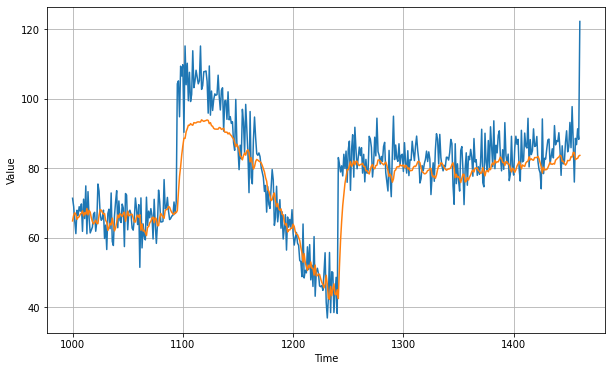

In [28]:
forecast = []
results = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size: ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.780809